## 2. Exploratory Data Analysis

To-dos:

* Add dynamic filters for plotly chart `ServiceStationName` and `FuelCode`

# Step 1: Getting started

First we're going to load in the data we prepared in notebook [1. Data Acquisition](1. Data Acquisition.ipynb) and have a quick look at it's structure:

In [5]:
import pandas as pd

data = pd.read_csv('../data/price_history.csv.gz', compression='gzip')

data.head(10)

,ServiceStationName,Address,Suburb,Postcode,Brand,FuelCode,PriceUpdatedDate,Price
0,Metro Petroleum Islington,"144 Maitland Rd, ISLINGTON NSW 2296",ISLINGTON,2296.0,Metro Fuel,E10,2017-10-01 00:02:52,116.9
1,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,E10,2017-10-01 00:08:44,119.9
2,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,P98,2017-10-01 00:08:44,139.9
3,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,U91,2017-10-01 00:08:44,122.9
4,Metro Minto,"1 Brookfield Road, Minto NSW 2566",Minto,2566.0,Metro Fuel,E10,2017-10-01 00:13:51,133.9
5,7-Eleven Penrith,"588 High Street, Penrith NSW 2751",Penrith,2751.0,7-Eleven,PDL,2017-10-01 00:24:40,125.9
6,Metro Fuel Berkeley,"57 Winnima Way, Berkeley NSW 2056",Berkeley,2056.0,Metro Fuel,E10,2017-10-01 05:03:52,114.9
7,Metro Fuel Berkeley,"57 Winnima Way, Berkeley NSW 2056",Berkeley,2056.0,Metro Fuel,U91,2017-10-01 05:03:52,116.9
8,Independent Wiley Park,"107 King Georges Rd, Wiley Park NSW 2195",Wiley Park,2195.0,Independent,E10,2017-10-01 05:18:53,135.9
9,Independent Wiley Park,"107 King Georges Rd, Wiley Park NSW 2195",Wiley Park,2195.0,Independent,P98,2017-10-01 05:18:53,149.9


We can see that we have `Price` at `PriceUpdatedDate`, for many combinations of `FuelCode` and `ServiceStationName`, and for each the relevant `Address`, `Suburb`, `Postcode` and `Brand`.

Now we want to start exploring the data. Looking at price changes over time seems like a good place to start.

To do that, we'll summarise `PriceUpdatedDate` (which is actually a *timestamp*) to the date level:

In [6]:
clean_data = data.copy()

# Convert PriceUpdateDate to datetime format
clean_data['PriceUpdatedDate'] = pd.to_datetime(clean_data['PriceUpdatedDate'])

# Extract the date component to a separate column
clean_data['PriceUpdatedDate_date'] = pd.to_datetime(clean_data['PriceUpdatedDate'].dt.date)

clean_data.head()

,ServiceStationName,Address,Suburb,Postcode,Brand,FuelCode,PriceUpdatedDate,Price,PriceUpdatedDate_date
0,Metro Petroleum Islington,"144 Maitland Rd, ISLINGTON NSW 2296",ISLINGTON,2296.0,Metro Fuel,E10,2017-10-01 00:02:52,116.9,2017-10-01
1,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,E10,2017-10-01 00:08:44,119.9,2017-10-01
2,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,P98,2017-10-01 00:08:44,139.9,2017-10-01
3,Independent Punchbowl,"10-12 Park Ave, Punchbowl NSW 2196",Punchbowl,2196.0,Independent,U91,2017-10-01 00:08:44,122.9,2017-10-01
4,Metro Minto,"1 Brookfield Road, Minto NSW 2566",Minto,2566.0,Metro Fuel,E10,2017-10-01 00:13:51,133.9,2017-10-01


Now we have everything we need to plot the mean `Price` reported daily:

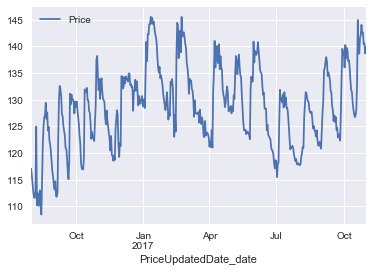

In [3]:
import seaborn as sns

% matplotlib inline

clean_data[['Price','PriceUpdatedDate_date']].groupby(['PriceUpdatedDate_date']).mean().plot();

Unforunately that is not all we have to do to create an accurate reflection of fuel prices across NSW. Since our data only reported *price changes*, what we have actually plotted is the mean *price update* daily.

Before we move on to that, we're going to create a station master file, which has records each unique service station:

In [19]:
(
    clean_data[['ServiceStationName','Address','Suburb','Postcode','Brand']]
    .groupby(['ServiceStationName','Address','Suburb','Postcode','Brand'])
    .count()
    .reset_index()
    .to_csv('../data/station_master.csv.gz', index=False, compression='gzip')
)

# Step 2: Calculating daily prices

To solve this problem and allow us to plot mean daily *price*, we'll need to do some more data preparation.

Over the same period as our data, for each known combination of `FuelCode`, `ServiceStationName` and date, we want to create a view price history by looking up the *last known* `Price` from our data above.

We'll start by finding all of the combinatiosn of `FuelCode` and `ServiceStationName`:

In [4]:
combos = clean_data[['FuelCode', 'ServiceStationName']].groupby(['FuelCode', 'ServiceStationName']).count().reset_index()

combos.head(10)

,FuelCode,ServiceStationName
0,B20,BP Port Kembla
1,B20,Independent Marrickville
2,B20,OneGov Testing & Support
3,CNG,Metro Petroleum Islington
4,CNG,Shell Gloucester
5,DL,7-Eleven Kanwal
6,DL,7-Eleven St Helens Park
7,DL,AP Punchbowl
8,DL,Aberdeen Fuels
9,DL,Access Fuels Ebor


Now we need to generate a list of all relevant dates, from the first and the last in our data:

In [5]:
first  = clean_data['PriceUpdatedDate_date'].min()
last = clean_data['PriceUpdatedDate_date'].max()

dates = pd.DataFrame(pd.date_range(first, last), columns=['Date'])
dates.head()

,Date
0,2016-08-01
1,2016-08-02
2,2016-08-03
3,2016-08-04
4,2016-08-05


For each combination, we'll create a row for each date. This will form the basis of our daily price calendar:

In [6]:
price_cal = pd.merge(combos.assign(key=0), dates.assign(key=0), on='key').drop('key', axis=1)
price_cal.head()

,FuelCode,ServiceStationName,Date
0,B20,BP Port Kembla,2016-08-01
1,B20,BP Port Kembla,2016-08-02
2,B20,BP Port Kembla,2016-08-03
3,B20,BP Port Kembla,2016-08-04
4,B20,BP Port Kembla,2016-08-05


Using our original data, we need to find the most recent price for each relevant `FuelCode`, `ServiceStationName` and `PriceUpdatedDate_date` combination.

To do this we'll first sort by `PriceUpdatedDate` (remember, this is actually a timestamp), then group the data using the three fields above, and take the *last* value for each:

In [7]:
last_price = clean_data.sort_values(by='PriceUpdatedDate', ascending=True)[['Price','FuelCode','ServiceStationName','PriceUpdatedDate_date']].groupby(['PriceUpdatedDate_date','FuelCode','ServiceStationName']).last().reset_index()
last_price.rename(columns = {'PriceUpdatedDate_date':'Date'}, inplace=True)
last_price.head()

,Date,FuelCode,ServiceStationName,Price
0,2016-08-01,DL,BP Airds,109.9
1,2016-08-01,DL,BP Blacktown,109.9
2,2016-08-01,DL,BP Cabramatta West,109.9
3,2016-08-01,DL,BP Kemps Creek,108.9
4,2016-08-01,DL,BP Leppington,108.9


With our base price calendar ready and all known prices, we can merge the two dataframes and fill the missing values using the `ffill` (forward fill) strategy. Each missing value takes the last known value.

In [15]:
daily_pricing = (
    pd.merge(price_cal, last_price, on=['Date','FuelCode','ServiceStationName'], how='left')
    .groupby(['FuelCode','ServiceStationName'], as_index=False)
    .fillna(method='ffill')
    .dropna()
)

daily_pricing.head(20)

,FuelCode,ServiceStationName,Date,Price
141,B20,BP Port Kembla,2016-12-20,55.9
142,B20,BP Port Kembla,2016-12-21,55.9
143,B20,BP Port Kembla,2016-12-22,55.9
144,B20,BP Port Kembla,2016-12-23,55.9
145,B20,BP Port Kembla,2016-12-24,55.9
146,B20,BP Port Kembla,2016-12-25,55.9
147,B20,BP Port Kembla,2016-12-26,55.9
148,B20,BP Port Kembla,2016-12-27,55.9
149,B20,BP Port Kembla,2016-12-28,55.9
150,B20,BP Port Kembla,2016-12-29,55.9


In [16]:
# Let's save a copy of the output
daily_pricing.to_csv('../data/daily_pricing.csv.gz', index=False, compression='gzip')

# Step 3: Visualise

In [2]:
# this just helps if you're picking up from Step 3 and don't want to run the entire notebook
if 'daily_pricing' not in globals():
    import pandas as pd
    daily_pricing = pd.read_csv('../data/daily_pricing.csv.gz', compression='gzip')

import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

selection = daily_pricing[(daily_pricing['ServiceStationName']=='BP Redfern') & (daily_pricing['FuelCode']=='P98')]

ts = [go.Scatter(x=selection.Date, y=selection.Price)]

py.iplot(ts)